In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import numpy as np
import seaborn as sns
import sqlite3
import sys
import itertools
sys.path.insert(1, "C:/Users/Eddie/Documents/language_change_methods")
sys.path.insert(1, "C:/Users/Eddie/Documents/language-change-application/flat-earth-forum/analysis")

from utility_functions import tokenise, get_time_windows, get_data_windows
from cross_entropy_models import BigramModel, SnapshotModels, SnapshotModelsPreset
from cross_entropy_sampling import plot_group_similarity_across_runs_stepped, get_end_of_windows


from helpers import load_posts, load_toks, load_pos

convert_to_date = lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S")
OUT_DIR = "C:/Users/Eddie/Documents/Datasets/Flat Earth Graphs/CE"

In [2]:
def read_subreddit(db_fp):
    conn = sqlite3.connect(db_fp)
    comments = pd.read_sql_query("SELECT uid, time FROM comments", conn)
    comments.set_index("uid", inplace=True)
    comments['time'] = comments['time'].apply(convert_to_date)
    comments.sort_values("time", inplace=True)
    return comments

In [3]:
def get_align_toks(tok_fp, posts):
    # Get the corresponding tokens
    toks = {x[0]: x[1] for x in load_toks(tok_fp)}
    toks = pd.Series(toks)
    toks = toks[toks.index.isin(posts.index)]

    # Remove the posts that don't have tokens
    posts = posts[posts.index.isin(toks.index)]
    # Align the ordering of forum posts and toks
    toks = toks.loc[posts.index]

    return toks, posts

In [4]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

In [5]:
def make_snapshots(posts, tok_fp):
    toks, posts = get_align_toks(tok_fp, posts)

    window_posts = {curr_date: curr_window
                       for curr_date, curr_window in get_data_windows(posts, 
                                                                      10000, 
                                                                      10000)}
    window_posts = pd.Series(window_posts)
    
    snaps = SnapshotModelsPreset(window_posts, toks)
    
    end_dates = get_end_of_windows(posts, get_data_windows, 10000, 10000)
    
    end_dates = pd.Series(end_dates, index=list(snaps.windows.keys()))
    
    return snaps, end_dates

In [6]:
forum_posts = load_posts("C:/Users/Eddie/Documents/Datasets/Flat Earth/little_fe_forum.db")
forum_posts.index = forum_posts.index.astype(str)

flat_earth_boards = [5, 7, 8, 19, 23]
other_boards = [9, 10, 11, 12]

fe_posts = forum_posts.query("board_id in @flat_earth_boards")

In [7]:
%%time

tfes_snaps, end_dates = make_snapshots(fe_posts, 
                                       "C:/Users/Eddie/Documents/Datasets/Flat Earth/TFES_CHUNKS_TOKENISED/tfes_posts.json")

Wall time: 21.4 s


In [8]:
with open("C:/Users/Eddie/Documents/Datasets/Reddit/FE/subreddit_ace_info.json") as curr_file:
    fe_subs_info = json.load(curr_file)
    
with open("C:/Users/Eddie/Documents/Datasets/Reddit/Other/subreddit_ace_info.json") as curr_file:
    ot_subs_info = json.load(curr_file)

## Get CE for each FE subreddit

In [9]:
def get_chunks(idx, tokens, chunk_size):
    for i in range(0, len(tokens)-chunk_size, chunk_size):
        yield idx, tokens[i:i+chunk_size]
        
def make_tok_chunks(tokens, chunk_size):
    chunks = [[[idx, chunk] for idx, chunk in get_chunks(idx, curr_toks, chunk_size)] for idx, curr_toks in tokens.items()]
    chunks = merge_lists(chunks)
    chunks = pd.DataFrame(chunks, columns=["idx", "chunk"])
    return chunks

In [10]:
def get_sub_ce(sub_info, snapshots):
    comments = read_subreddit(sub_info["db_fp"])
    toks, comments = get_align_toks(sub_info["tok_fp"], comments)
    chunks =  make_tok_chunks(toks, 30)
    chunk_info = comments.loc[chunks["idx"]]
    return snapshots.calculate_cross_entropies(chunks["chunk"], chunk_info["time"])

In [11]:
read_from_file = True

In [12]:
%%time
fe_sub_ce = dict()
for sub_info in fe_subs_info:
    sub_name = sub_info["name"]
    if read_from_file:
        fe_sub_ce[sub_name] = pd.read_csv(f"C:/Users/Eddie/Documents/Datasets/Reddit/FE/{sub_name}/{sub_name}_ce_to_forum.csv", 
                                          encoding="utf8", index_col=0, parse_dates=["date", "window"])
    else:
        fe_sub_ce[sub_name] = get_sub_ce(sub_info, tfes_snaps)

Wall time: 748 ms


In [13]:
%%time
ot_sub_ce = dict()
for sub_info in ot_subs_info:
    sub_name = sub_info["name"]
    if read_from_file:
        ot_sub_ce[sub_name] = pd.read_csv(f"C:/Users/Eddie/Documents/Datasets/Reddit/Other/{sub_name}/{sub_name}_ce_to_forum.csv", 
                                          encoding="utf8", index_col=0, parse_dates=["date", "window"])
    else:
        ot_sub_ce[sub_name] = get_sub_ce(sub_info, tfes_snaps)

Wall time: 2.12 s


In [14]:
%%time
if not read_from_file:
    for sub_name, ce in fe_sub_ce.items():
        ce.to_csv(f"C:/Users/Eddie/Documents/Datasets/Reddit/FE/{sub_name}/{sub_name}_ce_to_forum.csv", encoding="utf8")

    for sub_name, ce in ot_sub_ce.items():
        ce.to_csv(f"C:/Users/Eddie/Documents/Datasets/Reddit/Other/{sub_name}/{sub_name}_ce_to_forum.csv", encoding="utf8")

Wall time: 0 ns


## Plotting the CE

In [15]:
def get_ce_runs(chunk_ces, sample_size=None, n_samples=10):
    ce_runs = dict()
    for sub_name, ce in chunk_ces.items():
        if sample_size is None:
            curr_samp_size = int(0.5 * len(ce))
        
        curr_runs = [ce.sample(curr_samp_size, random_state=i).groupby("window").mean()["cross-entropy"] 
                     for i in range(n_samples)]
        curr_runs = pd.concat(curr_runs, axis=1)
        curr_runs.columns = range(n_samples)
        ce_runs[sub_name] = curr_runs
    return ce_runs

In [16]:
# Assign colours
colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "black", "#a65628", "#f781bf"]
marker_list = ["-", "-", ":", ":", "--", "--", "-.", "-."]

sub_names = list(fe_sub_ce)
fe_colour_dict = {sub: col for sub, col in zip(sub_names, colour_list)}
fe_marker_dict = {sub: mar for sub, mar in zip(sub_names, marker_list)}

sub_names = list(ot_sub_ce)
ot_colour_dict = {sub: col for sub, col in zip(sub_names, colour_list)}
ot_marker_dict = {sub: mar for sub, mar in zip(sub_names, marker_list)}

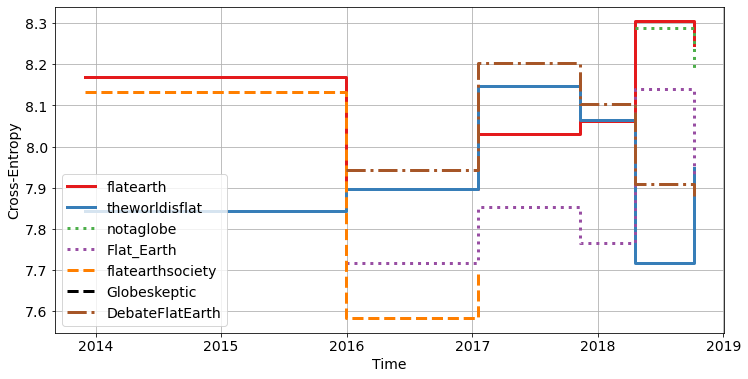

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in fe_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    ax.plot(avg_ce_over_time, label=sub_name, drawstyle='steps-post', 
            color=fe_colour_dict[sub_name], linestyle=fe_marker_dict[sub_name], lw=3)
    
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Cross-Entropy", fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.grid()
ax.legend(fontsize=14)
plt.show()

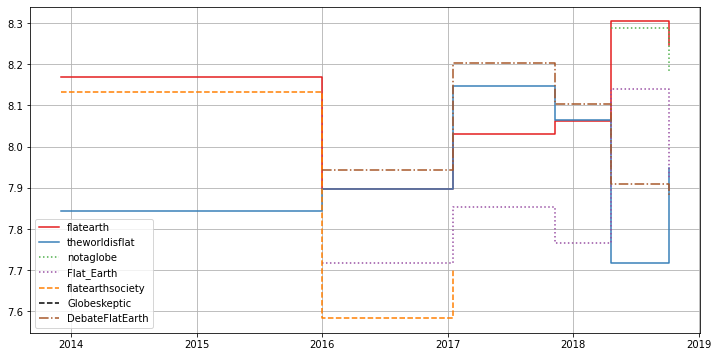

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in fe_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    ax.plot(avg_ce_over_time, label=sub_name, drawstyle='steps-post', 
            color=fe_colour_dict[sub_name], linestyle=fe_marker_dict[sub_name])
    
ax.grid()
ax.legend()
plt.show()

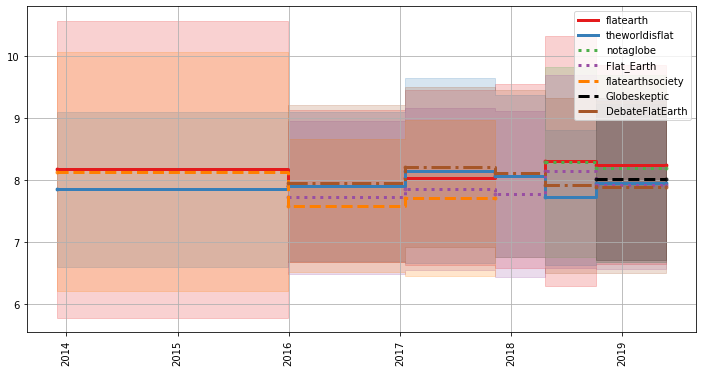

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in fe_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]
    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=fe_colour_dict[sub_name], 
                                              line_style=fe_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    
ax.grid()
ax.legend()
plt.show()

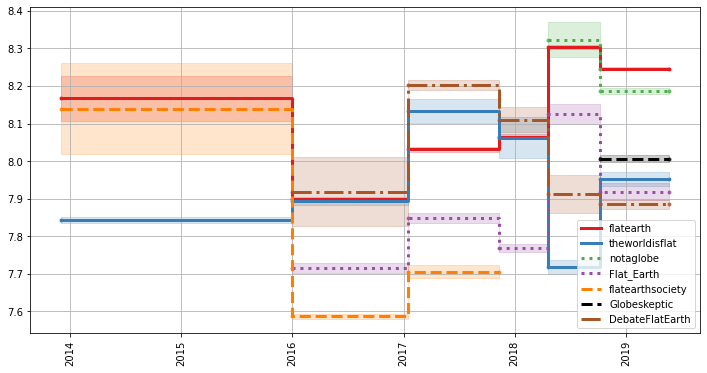

Wall time: 694 ms


In [20]:
%%time
fig, ax = plt.subplots(figsize=(12, 6))

ce_runs = get_ce_runs(fe_sub_ce)

for sub_name, ce_run in ce_runs.items():
    avg_ce_over_time = ce_run.mean(axis=1)
    std_ce_over_time = ce_run.std(axis=1)
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]
    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=fe_colour_dict[sub_name], 
                                              line_style=fe_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    
ax.grid()
ax.legend()
plt.show()

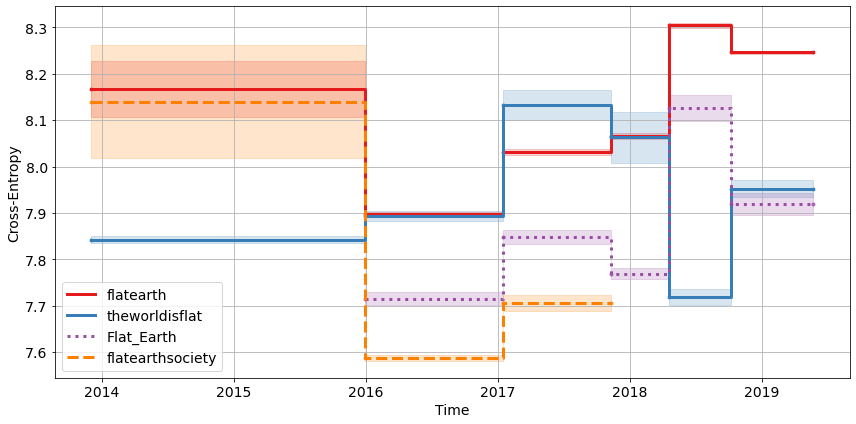

Wall time: 752 ms
Compiler : 221 ms


In [21]:
%%time
fig, ax = plt.subplots(figsize=(12, 6))

ce_runs = get_ce_runs(fe_sub_ce)

ce_runs = {g: r for g, r in ce_runs.items() if g in ["flatearth", "flatearthsociety", "Flat_Earth", "theworldisflat"]}

for sub_name, ce_run in ce_runs.items():
    avg_ce_over_time = ce_run.mean(axis=1)
    std_ce_over_time = ce_run.std(axis=1)
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]
    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=fe_colour_dict[sub_name], 
                                              line_style=fe_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    

ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cross-Entropy", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.grid()
ax.legend(fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "fe_reddit_ce_to_tfes.pdf"))
plt.show()

## Conspiracy and Science

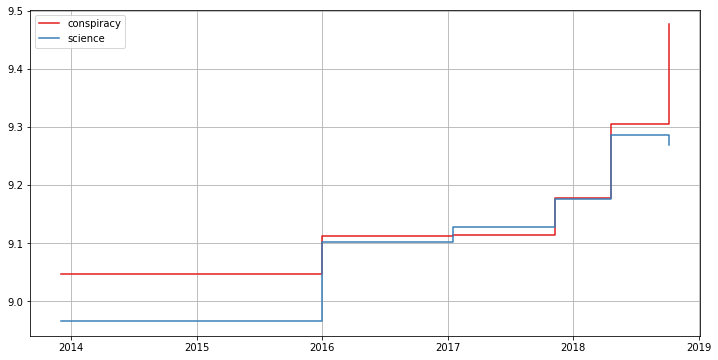

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in ot_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    ax.plot(avg_ce_over_time, label=sub_name, drawstyle='steps-post', 
            color=ot_colour_dict[sub_name], linestyle=ot_marker_dict[sub_name])
    
ax.grid()
ax.legend()
plt.show()

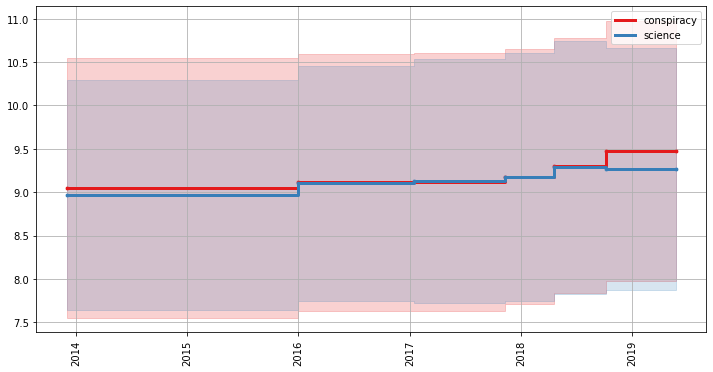

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in ot_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]
    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=ot_colour_dict[sub_name], 
                                              line_style=ot_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    
ax.grid()
ax.legend()
plt.show()

In [24]:
ce_runs = get_ce_runs(ot_sub_ce)
ce_runs["conspiracy"]

0         1         2         3         4  \
window                                                                  
2013-12-01 18:43:04  9.046949  9.047347  9.049544  9.047312  9.046835   
2015-12-30 23:54:31  9.118795  9.116449  9.104058  9.117656  9.120501   
2017-01-16 01:34:55  9.116693  9.115170  9.111764  9.110492  9.112787   
2017-11-09 16:57:19  9.176989  9.175027  9.181647  9.179344  9.183481   
2018-04-20 09:03:11  9.304179  9.316374  9.305748  9.304761  9.303806   
2018-10-07 05:55:37  9.479089  9.475314  9.474672  9.475617  9.477029   

                            5         6         7         8         9  
window                                                                 
2013-12-01 18:43:04  9.049004  9.048337  9.046409  9.048118  9.044101  
2015-12-30 23:54:31  9.112853  9.106301  9.116155  9.113383  9.115042  
2017-01-16 01:34:55  9.119785  9.103201  9.114038  9.113332  9.116762  
2017-11-09 16:57:19  9.178294  9.171246  9.175914  9.183416  9.184746  
2018-04-20 09:03:11  9.305174  9.300993  9.300438  9.298960  9.296871  
2018-10-07 05:55:37  9.480880  9.476621  9.471708  9.476831  9.474216

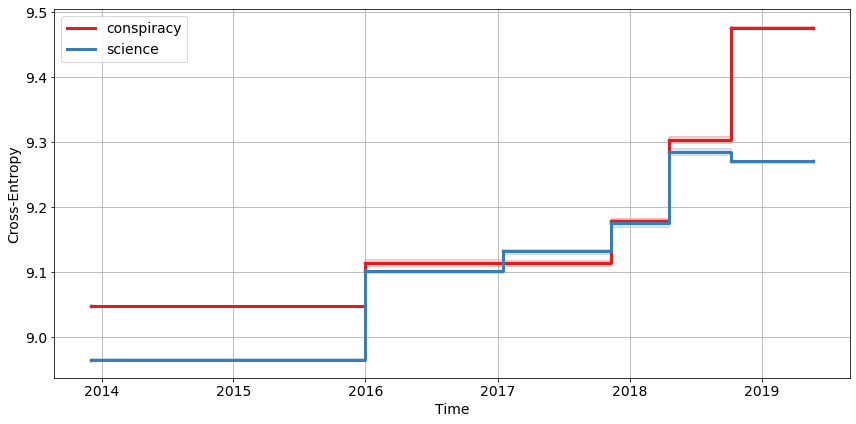

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce_run in ce_runs.items():
    avg_ce_over_time = ce_run.mean(axis=1)
    std_ce_over_time = ce_run.std(axis=1)
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]

    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=ot_colour_dict[sub_name], 
                                              line_style=ot_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cross-Entropy", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.grid()
ax.legend(fontsize=14)

plt.tight_layout()

fig.savefig(os.path.join(OUT_DIR, "ot_reddit_ce_to_tfes.pdf"))
plt.show()